# StateOrdering.ipynb
## Ordering and visualizing state associations for hidden Markov models

Here I will demonstrate two ways to order states of a hidden Markov model, with a key assumption being that cells/units have no defined topography/topology. That is, in the hippocampus, (place) cells are recruited at random, and neighboring place cells are not guaranteed to have adjacent or even nearby place fields. This lack of cellular topology motivates us to use the Hellinger distance, described later, whereas if the cellular topology _is_ important, then we can consider something like the Wasserstein (earth mover's) distance instead.

First, it should be obvious that state labels from a hidden Markov model are arbitrary, and the model itself does not impose any ordering on the set of states. However, in practice we may very well be interested to know that states $i$ and $j$ are "closer" to each other than states $i$ and $k$, for example.

The first ordering approach I will consider, is based simply on a greedy re-ordering of the states based on their transition probabilities. We start with any state, say $S_0=i$, and then greedily select the next state, which has highest probability of occurence after $i$, and so on. This ordering is not necessarily optimal in any sense, but it should be close to optimal in many ways that make sense. However, two limitations to such an approach include the (i) linear ordering, and the (ii) lack of distance information. For example, if we have a T-maze, then what ordering should we choose? At some point, the greedy algorithm might be forced to group two states together that are nowhere close to each other. Second, we have no information to know how much closer two adjacent states are to each other than to a neighbor one or two spaces removed.

Both of the above limitations can be mitigated to some extent by using multidimensional scaling (MDS), Isomap, or some similar techniques. Here I consider MDS, where we attempt to find an optimal embedding of the states in a 2-dimensional or a 1-dimensional space, depending on our belief about the underlying environment. 

In particular, I use the Hellinger distance to compute point-wise distances between different state-unit pairs. For example, for any pair of states $S_A$ and $S_B$ and an associated unit $u$, we have Poisson firing rates $u_A$ and $u_B$, so that we compute the squared Hellinger distance between these Poisson distributions as
$$
H^2\bigl(S_A(u),S_B(u)\bigr) = 1-\exp\biggl(-\frac{1}{2}\bigl(\sqrt{u_A} - \sqrt{u_B}\bigr)^2\biggr).
$$
Then we simply consider the pairwise distance between the two states as the average Hellinger distance over all the units:
$$
D(S_A,S_B) = \dfrac{1}{|U|}\sum_{u \in U} H\bigl(S_A(u), S_B(u) \bigr).
$$

Using $D$ as our distance function in MDS and projecting the data onto a 1-dimensional subspace then reveals both an ordering for the states, as well as approximate distances between those states, allowing us to make observations such as "state $i$ is much more similar to state $j$ than it is to state $k$," and so on. Of course, if we project it onto a 2-dimensional subspace, then we could potentially learn even more about the state associations, in that we can learn about state adjecency and proximity even when the underlying states cannot be described by a simple linear ordering.

**Idea:** Perhaps I should simulate this with a T or 3-arm maze (or even an $N$-arm maze) and show how the state associations can reveal the nonexistence of a suitable linear ordering.

**Remark 1:** The above approaches have been designed with the assumption that we need to do this in a completely unsupervised manner. Of course, if we actually have some position data for the animals, we can create a heatmap of the decoded states, allowing us to assign the states to the modes of their spatial distributions. This idea is not demonstrated here, but is used in ```StateClustering.ipynb``` to show place fields learned on the linear track.

**Remark 2:** _**Spoiler Alert!**_ The MDS approach did not work as well as I had hoped or expected. In particular, there seems to be many local minima that the approach settles in, so that finding a robust ordering is made difficult. Furthermore, the Hellinger distance based approach did not necessarily lead to better results. Indeed, it is difficult to say which metric actually performed better. Nevertheless, there are some other manifold learning approaches that we could try, as well as some other pairwise metrics, that might lead to sensible or useable solutions. It is not as if the approach did not work _at all_, but it did not work very well. I am however not ready to give up on it, because it is conceptually appealing, and it is theoretically powerful.


### Import packages and initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

sys.path.insert(0, 'helpers')

from efunctions import * # load my helper function(s) to save pdf figures, etc.
from hc3 import load_data, get_sessions
from hmmlearn import hmm # see https://github.com/ckemere/hmmlearn
import klabtools as klab
import seqtools as sq

import importlib

importlib.reload(sq) # reload module here only while prototyping...
importlib.reload(klab) # reload module here only while prototyping...

%matplotlib inline

sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 1.5})
sns.set_style("white")

function saveFigure(filename) loaded

Tip: to save a figure, call saveFigure("path/figure.pdf")


### Load data
Here we consider lin2 data for gor01 on the first recording day (6-7-2006), since this session had the most units (91) of all the gor01 sessions, and lin2 has position data, whereas lin1 only has partial position data.

In [2]:
datadirs = ['/home/etienne/Dropbox/neoReader/Data',
            'C:/etienne/Dropbox/neoReader/Data',
            '/Users/etienne/Dropbox/neoReader/Data']

fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)

animal = 'gor01'; month,day = (6,7); session = '16-40-19' # 91 units

spikes = load_data(fileroot=fileroot, datatype='spikes',animal=animal, session=session, month=month, day=day, fs=32552, verbose=False)
eeg = load_data(fileroot=fileroot, datatype='eeg', animal=animal, session=session, month=month, day=day,channels=[0,1,2], fs=1252, starttime=0, verbose=False)
posdf = load_data(fileroot=fileroot, datatype='pos',animal=animal, session=session, month=month, day=day, verbose=False)
speed = klab.get_smooth_speed(posdf,fs=60,th=8,cutoff=0.5,showfig=False,verbose=False)

reading position data from 'C:\etienne\Dropbox\neoReader\Data/gor01-6-7/2006-6-7_16-40-19/2006-6-7_16-40-19.whl'


In [3]:
## bin ALL spikes
ds = 0.125 # bin spikes into 125 ms bins (theta-cycle inspired)
binned_spikes = klab.bin_spikes(spikes.data, ds=ds, fs=spikes.samprate, verbose=True)

## identify boundaries for running (active) epochs and then bin those observations into separate sequences:
runbdries = klab.get_boundaries_from_bins(eeg.samprate,bins=speed.active_bins,bins_fs=60)
binned_spikes_bvr = klab.bin_spikes(spikes.data, fs=spikes.samprate, boundaries=runbdries, boundaries_fs=eeg.samprate, ds=ds)

## stack data for hmmlearn:
seq_stk_bvr = sq.data_stack(binned_spikes_bvr, verbose=True)
seq_stk_all = sq.data_stack(binned_spikes, verbose=True)

## split data into train, test, and validation sets:
tr_b,vl_b,ts_b = sq.data_split(seq_stk_bvr, tr=60, vl=10, ts=30, randomseed = 0, verbose=True)

## train HMM on active behavioral data; training set (with a fixed, arbitrary number of states for now):
myhmm = sq.hmm_train(tr_b, num_states=35, n_iter=50, verbose=False)

binning data into 20703 x 125.0 ms temporal bins...
90 sequences being stacked...
Total sequence length: 1938 bins, each of width 0.125 seconds
Successfully stacked 90 sequences for a total of 242.25 seconds of data.
Only one sequence in data; so data is already in stacked format...
Splitting 90 sequences into train, validation, and test sets...
54 sequences being stacked...
Total sequence length: 1163 bins, each of width 0.125 seconds
Successfully stacked 54 sequences for a total of 145.38 seconds of data.
9 sequences being stacked...
Total sequence length: 174 bins, each of width 0.125 seconds
Successfully stacked 9 sequences for a total of 21.75 seconds of data.
27 sequences being stacked...
Total sequence length: 601 bins, each of width 0.125 seconds
Successfully stacked 27 sequences for a total of 75.12 seconds of data.
Stacked data split into train (60.0 %), validation (10.0 %) and test (30.0 %) sequences.


## Approach 1: linear ordering of states using the state transition probability matrix
Here we sort states in a greedy manner using the state transition probability matrix. We can choose an arbitrary state as our first state, and then greedily select the most likely state to follow our first state, followed by the most likely state from the remaining unsorted states, and so on. 

We will use RUN > 8 data to train an $m=35$ state HMM. This number of states might not be optimal (indeed, we can optimize this parameter for any given dataset using a validation set), but we have also previously shown that the number of states does not make a big difference in the model performance. That is, the analyses are fairly insensitive to the actual number of states, which is a very good thing. Anything from around $m=25$ to $m=50$ could make sense, but we can get meaningful results even for $m=10$ state models.

In [4]:
# sort model states:
def get_sorted_order_from_transmat(A, start_state = 0):
    
    new_order = [start_state]
    num_states = A.shape[0]
    rem_states = np.arange(0,start_state).tolist()
    rem_states.extend(np.arange(start_state+1,num_states).tolist())
    cs = start_state

    for ii in np.arange(0,num_states-1):
        nstilde = np.argmax(A[cs,rem_states])
        ns = rem_states[nstilde]
        rem_states.remove(ns)
        cs = ns
        new_order.append(cs)
        
    return new_order, A[:, new_order][new_order]

new_order, Anew = get_sorted_order_from_transmat(myhmm.transmat_, start_state = 17)

[]

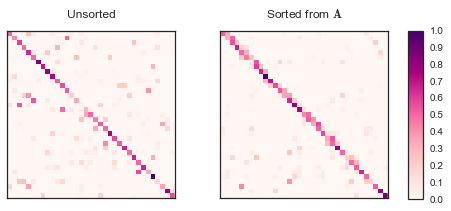

In [5]:
myhmm.transmat_.sum(axis=1) # confirm orientation of transition prob matrix
A = myhmm.transmat_.copy()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
im = ax1.matshow(A, interpolation='none', cmap='RdPu')
ax2.matshow(Anew, interpolation='none', cmap='RdPu')
# Make an axis for the colorbar on the right side
cax = fig.add_axes([0.93, 0.12, 0.03, 0.78])
fig.colorbar(im, cax=cax)
ax1.set_title('Unsorted')
ax2.set_title('Sorted from $\mathbf{A}$')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])

**Remarks:** First notice that the state transition probability matrix is almost diagonal. However, after sorting, we can see the banded structure, showing the strong Markovian dynamics of the underlying data.

We might be interested to know how much better sequences look after this greedy rearrangement? To illustrate the difference, we will show sequences from the RUN test set (never before seen by the model) both before and after sorting.

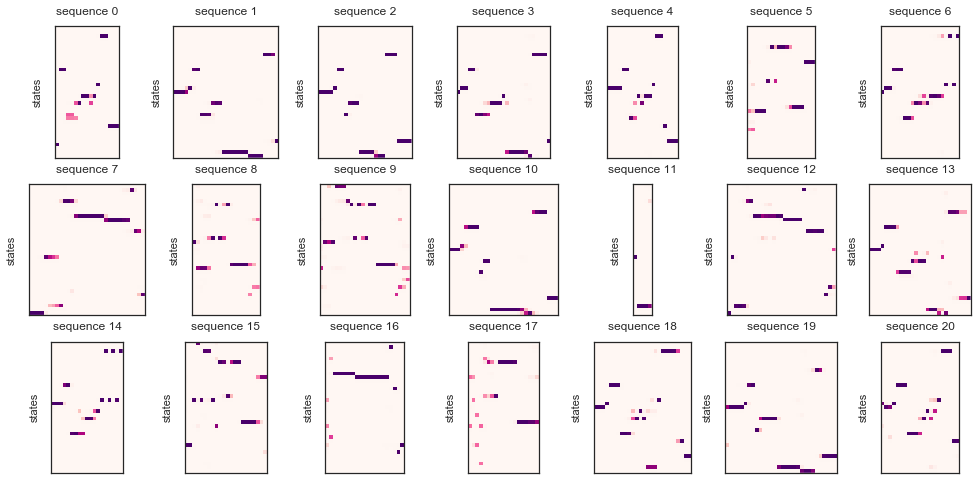

In [6]:
tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(ts_b.sequence_lengths).tolist());

fig, axes = plt.subplots(3, 7, figsize=(17, 8))
axes = [item for sublist in axes for item in sublist]

for ii, ax in enumerate(axes):
    obs = ts_b.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm.score_samples(obs)
    ax.matshow(np.transpose(pp), interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')


Now we show the same sequences after applying our new ordering:

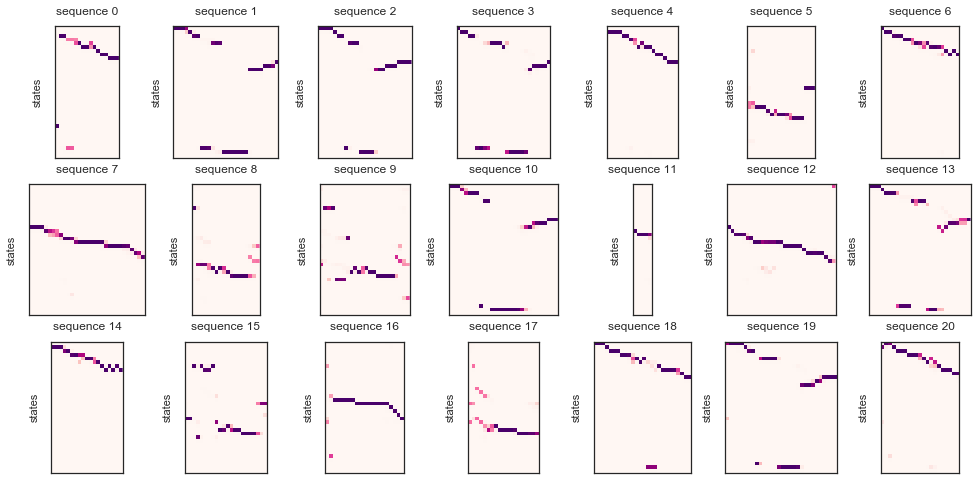

In [344]:
start_state = 17

new_order, Anew = get_sorted_order_from_transmat(myhmm.transmat_, start_state=start_state)
tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(ts_b.sequence_lengths).tolist());

fig, axes = plt.subplots(3, 7, figsize=(17, 8))
axes = [item for sublist in axes for item in sublist]

for ii, ax in enumerate(axes):
    obs = ts_b.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm.score_samples(obs)
    ax.matshow(np.transpose(pp)[new_order,:], interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')


**Remarks:** We can clearly see that the second ordering is better, in the sense that sequential structures are more apparent. The ordering (or the decoding) is not perfect however, which may be due to the greedy nature of the ordering, or simply variability in the neural signals.

Here choosing a good ```starting_state``` can also influence the visual results, but thankfully neither the ordering, nor the ```starting_state``` should affect our analyses in general.

### What about ordering the states based on their peak locations on the track? (Assuming pos data known)
**Warning:** The results below highlight a part of my codebase that I need to re-write. In particular, when I bin data for analysis, I can take two approaches: (i) find eeg sample numbers for which the animal was running above threshold, and then find the smallest number of bins to cover each segment, or (ii) bin all the data, and extract the bins for which the animal was running above threshold.

The first approach gives a finer scale for starting sequences, but it makes it hard to do some other parts of my analyses because of how my code has been designed (getting the true position, for one thing...). In this approach, it is also not a trivial matter to take the complement of the running bins, since the complement will most likely not be an integral multiple of the bin size. It is also much slower to compute as compared to binning all the data, and then extracting relevant bins.

However, training data on the pre-binning approach (which we do below) gives strange state sequences. I did not notice this when looking at the place fields, where I also used such a binning approach, and technically there is nothing _wrong_ with what I see, but it is not what I _wanted_ to see. **What is going on? Why the difference? How should I re-write my code to make the two approaches more similar?**

**UPDATE:** See the remarks at the end of this section for a possible explanation and intuition of what's going on here, and why it may not be a problem.

In [8]:
from mymap import Map

def extract_subsequences_from_binned_spikes(binned_spikes, bins):
    data = spikes.data.copy()
    boundaries = klab.get_continuous_segments(bins)
    
    binned = Map()
    binned['bin_width'] = binned_spikes.bin_width
    binned['data'] = binned_spikes.data[bins,:]
    binned['boundaries'] = boundaries
    binned['boundaries_fs'] = 1/binned_spikes.bin_width   
    binned['sequence_lengths'] = (boundaries[:,1] - boundaries[:,0] + 1).flatten()
    
    return binned

In [9]:
## bin ALL spikes
ds = 0.125 # bin spikes into 125 ms bins (theta-cycle inspired)
binned_spikes = klab.bin_spikes(spikes.data, ds=ds, fs=spikes.samprate, verbose=True)

centerx = (np.array(posdf['x1']) + np.array(posdf['x2']))/2
centery = (np.array(posdf['y1']) + np.array(posdf['y2']))/2

tend = len(speed.data)/speed.samprate # end in seconds
time_axis = np.arange(0,len(speed.data))/speed.samprate
speed_125, tvel_125 = klab.resample_velocity(velocity=speed.data,t_bin=ds,tvel=time_axis,t0=0,tend=tend)
truepos_125 = np.interp(np.arange(0,len(binned_spikes.data))*ds,time_axis,centerx)

# get bins where rat was running faster than thresh units per second
runidx_125 = np.where(speed_125>8)[0]
seq_stk_run_125 = extract_subsequences_from_binned_spikes(binned_spikes,runidx_125)

## split data into train, test, and validation sets:
tr_b2,vl_b2,ts_b2 = sq.data_split(seq_stk_run_125, tr=60, vl=10, ts=30, randomseed = 0, verbose=True)

## train HMM on active behavioral data; training set (with a fixed, arbitrary number of states for now):
myhmm2 = sq.hmm_train(tr_b2, num_states=35, n_iter=50, verbose=False)

binning data into 20703 x 125.0 ms temporal bins...
Splitting 90 sequences into train, validation, and test sets...
54 sequences being stacked...
Total sequence length: 1135 bins, each of width 0.125 seconds
Successfully stacked 54 sequences for a total of 141.88 seconds of data.
9 sequences being stacked...
Total sequence length: 170 bins, each of width 0.125 seconds
Successfully stacked 9 sequences for a total of 21.25 seconds of data.
27 sequences being stacked...
Total sequence length: 591 bins, each of width 0.125 seconds
Successfully stacked 27 sequences for a total of 73.88 seconds of data.
Stacked data split into train (60.0 %), validation (10.0 %) and test (30.0 %) sequences.


In [10]:
###########################################################3
stacked_data = seq_stk_run_125
###########################################################3

x0=0; xl=100; num_pos_bins=50
xx_left = np.linspace(x0,xl,num_pos_bins+1)
num_sequences = len(stacked_data.sequence_lengths)
num_states = myhmm.n_components
state_pos = np.zeros((num_states, num_pos_bins))

for seq_id in np.arange(0,num_sequences):
    tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(stacked_data.sequence_lengths).tolist());
    obs = stacked_data.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
    ll, pp = myhmm2.score_samples(obs)
    xx = truepos_125[stacked_data.boundaries[seq_id,0]:stacked_data.boundaries[seq_id,1]+1]
    digitized = np.digitize(xx, xx_left) - 1 # spatial bin numbers
    for ii, ppii in enumerate(pp):
        state_pos[:,digitized[ii]] += np.transpose(ppii)

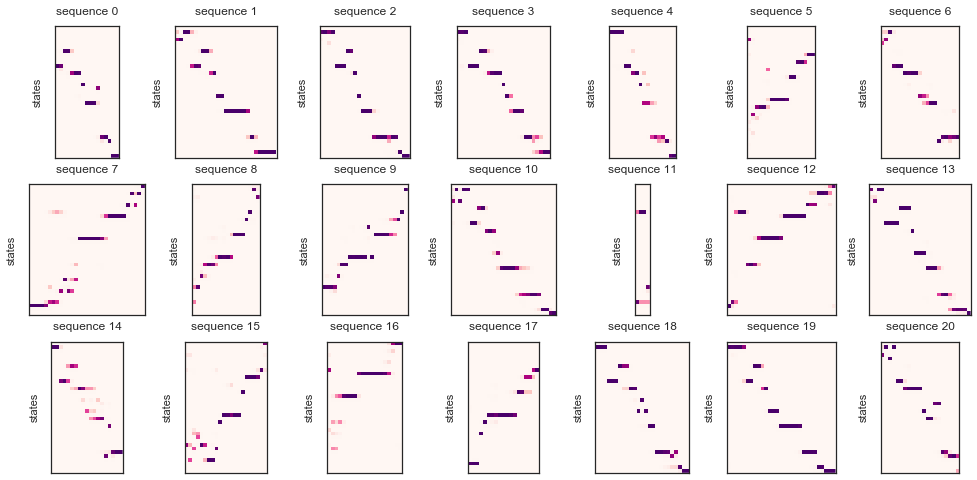

In [11]:
## now order states by peak location on track
peaklocations = state_pos.argmax(axis=1)
peak_order = peaklocations.argsort()

tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(ts_b2.sequence_lengths).tolist());

fig, axes = plt.subplots(3, 7, figsize=(17, 8))
axes = [item for sublist in axes for item in sublist]

for ii, ax in enumerate(axes):
    obs = ts_b2.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm2.score_samples(obs)
    ax.matshow(np.transpose(pp)[peak_order,:], interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')


**Remarks:** Apart from the strange ?sparseness? of my state sequences, we do see clear continuity for all the sequences considered when ordering by the peak locations of the learned place fields. I am really anxious to understand why my state distributions are so different than when I take the alternative post-binning approach as opposed to the pre-binning approach taken here.

**Possible explanation:** Perhaps this state-sparseness shouldn't make me too worried—perhaps it is really simply due to the peak ordering of the states? So if the animal runs faster than the typical state-to-state transitions, then the above sequences actually make a lot of sense.

For example, $S_1 \rightarrow S_4 \rightarrow S_7$ and $S_2 \rightarrow S_5 \rightarrow S_8$ could look like the above sequences, where the peak ordering would be $(S_1,S_2,\ldots, S_8)$, whereas the state adjacency ordering would be different, such that $(S_1,S_4,S_7)$ and $(S_2,S_5,S_7)$ should appear somewhere in the ordering.

This observation might actually also help explain why some sequences in the state transition probability matrix ordered approach appear continuous, while other appear only piece-wise continuous.

## Approach 2: generalized state associations using multidimensional scaling (MDS)
Here we will consider multidimensional scaling (MDS) using a pairwise Poisson Hellinger based metric (expect to work well) and a Euclidean distance (expect to work less well).

For a comparison between some of the different alternatives, consider looking at
* http://scikit-learn.org/stable/modules/manifold.html#manifold-learning and
* http://www.cs.cmu.edu/~efros/courses/AP06/presentations/melchior_isomap_demo.pdf

**Note:** The purpose of the MDS is to find a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space, unlike other manifold-learning algorithms, it does not seek an isotropic representation of the data in the low-dimensional space. Isomap might be conceptually more appealing, especially for recovering the topology of an environment...

### How will we know if MDS is working?

It is perhaps useful to first spend some time thinking about what we would hope or expect to see when we use MDS to recover an ordering of states. 

In particular, we _could_ condiser the continuity of tuning curves. Recall that for each unit, the associated tuning curve lies in a $m$-dimensional space, where $m$ is the number of states of the HMM. As a consequence, we expect to see, on average, smoother tuning curves within each unit if a proper state ordering is used.

An example is shown below, with an arbitrary ordering on the left, and the ordering obtained by greedily using the next most likely state from the state transition probability matrix, on the right:

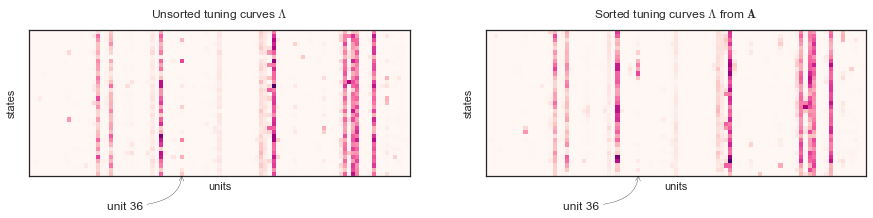

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))

ax1.matshow(myhmm.means_, interpolation='none', cmap='RdPu')
ax2.matshow(myhmm.means_[new_order,:], interpolation='none', cmap='RdPu')

ax1.set_title('Unsorted tuning curves $\Lambda$')
ax2.set_title('Sorted tuning curves $\Lambda$ from $\mathbf{A}$')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_ylabel('states')
ax1.set_xlabel('units')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_ylabel('states')
ax2.set_xlabel('units')

ax1.annotate('unit 36', xy=(36, 34), xycoords='data',
                xytext=(-75, -35), textcoords='offset points',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle3,angleA=0,angleB=-90"),
                )

ax2.annotate('unit 36', xy=(36, 34), xycoords='data',
                xytext=(-75, -35), textcoords='offset points',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle3,angleA=0,angleB=-90"),
                )


Note that in the above figures, unit 36 has been higlihted, showing clearly that after re-ordeing, the tuning curve is more smooth than before ordering. Several other examples can also be seen in the above figure, but it is made a little difficult to see because of the dominance of some non-place-specific neurons (potentially interneurons due to high firing rates) which show up as the bright vertical bands of all-state activity.

Another, perhaps more reliable, metric of smoothness is to consider the variance in the firing rates between adjacent states. More specifically, we consider the differences $f_u(S=i) = \lambda(S=i+1;u) - \lambda(S=i;u)$, where $\lambda(S;u) \equiv \Lambda_{u,S}$, the learned tuning curves ($\Lambda \in \mathbb{R}^{m \times C}$) corresponding to unit $u$ and state $S$.

In [42]:
A = myhmm.means_.copy()
f = np.diff(A)
f.shape

(35, 90)

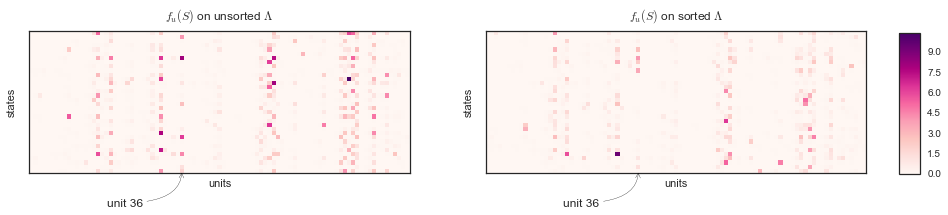

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))

A = myhmm.means_.copy()
f1 = np.diff(A, axis=0)
f2 = np.diff(A[new_order,:], axis=0)

vmin=0; vmax=np.max([f1.max(),f2.max()])

im = ax1.matshow(f1, interpolation='none', cmap='RdPu', vmin=vmin, vmax=vmax)
ax2.matshow(f2, interpolation='none', cmap='RdPu', vmin=vmin, vmax=vmax)

ax1.set_title('$f_u(S)$ on unsorted $\Lambda$')
ax2.set_title('$f_u(S)$ on sorted $\Lambda$')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_ylabel('states')
ax1.set_xlabel('units')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_ylabel('states')
ax2.set_xlabel('units')

ax1.annotate('unit 36', xy=(36, 33), xycoords='data',
                xytext=(-75, -35), textcoords='offset points',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle3,angleA=0,angleB=-90"),
                )

ax2.annotate('unit 36', xy=(36, 33), xycoords='data',
                xytext=(-75, -35), textcoords='offset points',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle3,angleA=0,angleB=-90"),
                )

# Make an axis for the colorbar on the right side
cax = fig.add_axes([0.93, 0.18, 0.02, 0.65])
fig.colorbar(im, cax=cax)

We can quantify the variability further, by computing the the variance within each unit (that is, across states), and ultimately computing the average within-unit (or equivalently across-state) variance as shown below:

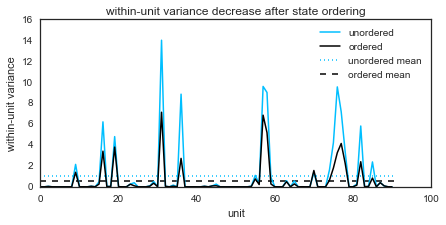

In [125]:
v1 = np.var(f1,axis=0); v2 = np.var(f2,axis=0)

fig, ax1 = plt.subplots(1, 1, figsize=(7, 3))
ax1.plot(v1, label='unordered', color='deepskyblue')
ax1.plot(v2, label='ordered', color='k')
ax1.hlines(v1.mean(), xmin=0, xmax=len(v1), colors='deepskyblue', linestyles='dotted', label='unordered mean')
ax1.hlines(v2.mean(), xmin=0, xmax=len(v2), colors='k', linestyles='dashed', label='ordered mean')
ax1.legend()
ax1.set_xlabel('unit')
ax1.set_ylabel('within-unit variance')
ax1.set_title('within-unit variance decrease after state ordering')

As expected, we can see a reduction in the within-state variance after re-ordering. Perhaps somewhat surprisingly, we see that the variance was _uniformly_ reduced, which is by no means guaranteed by our greedy approach.

Next, we will consider manifold learning, and MDS in particular, and we will consider yet another way of assessing the within-state variance.

### Multidimensional scaling (MDS)
First, we use the Euclidean distance between states, where for each state, we have an associated $C$-dimensional vector of firing rates (here $C \equiv |\mathcal{U}|$, the number of units). We embed the distances in a 2-dimensional space so that we can view both a rough state ordering, but also relative similarities between different states.

In [380]:
def poisson_hellinger_distances(tmat):
    # tmat is N x p : N observations in a p-dimensional space
    N, p = tmat.shape
    D = np.zeros((N,N))
    sqrtmat = np.sqrt(tmat)
    
    for ii in np.arange(0, N):
        for jj in np.arange(ii, N):
            D[ii,jj] = np.sqrt(1 - np.exp(-0.5*(sqrtmat[ii,:] - sqrtmat[jj])**2)).mean()
            D[jj,ii] = D[ii,jj]
    return D

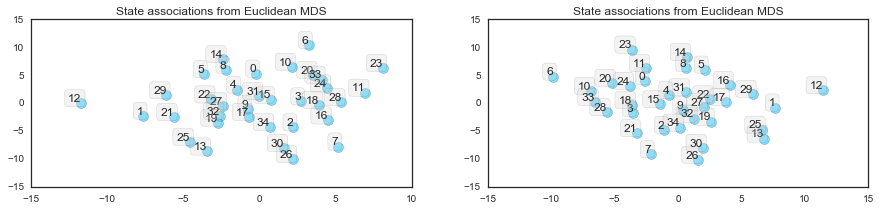

In [381]:
from sklearn import manifold
from sklearn.metrics import euclidean_distances

seed1 = np.random.RandomState(seed=3)
seed2 = np.random.RandomState(seed=4)

num_states = myhmm.n_components
similarities = euclidean_distances(myhmm.means_)
similaritiesHP = poisson_hellinger_distances(myhmm.means_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed1,
                   dissimilarity="precomputed", n_jobs=1)

pos = mds.fit(similarities).embedding_

labels = ['{0}'.format(i) for i in range(num_states)]
ax1.scatter(pos[:, 0], pos[:, 1], s=100, c='deepskyblue', alpha=0.5)

for label, x, y in zip(labels, pos[:, 0], pos[:, 1]):
    ax1.annotate(
        label, 
        xy = (x, y), xytext = (0, 0),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round', fc = 'lightgray', alpha = 0.25))
ax1.set_title('State associations from Euclidean MDS')
    
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed2,
                   dissimilarity="precomputed", n_jobs=1)

pos = mds.fit(similarities).embedding_

labels = ['{0}'.format(i) for i in range(num_states)]
ax2.scatter(pos[:, 0], pos[:, 1], s=100, c='deepskyblue', alpha=0.5)

for label, x, y in zip(labels, pos[:, 0], pos[:, 1]):
    ax2.annotate(
        label, 
        xy = (x, y), xytext = (0, 0),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round', fc = 'lightgray', alpha = 0.25))
ax2.set_title('State associations from Euclidean MDS')

**Discussion:** We have shown two realizations (or solutions) to the MDS problem above. Encouragingly, many state associateds or distances are similar. For example, consider the set of states $\{S_{12}, S_1, S_{29}, S_{21}, S_{25}, S_{13}\}$. These are all clustered relatively closely to each other (in both solutions), and $S_{13}$ and $S_{25}$ are _very similar_. We also learn that state $S_1$ is _more similar_ to $S_{12}$ than say $S_{25}$, and so on. In fact, we see many, many similarities between the two solutions, but we also see some differences. For example, on the left, $S_{12}$ and $S_{23}$ are the _most different_ states, whereas on the right, $S_{12}$ and $S_6$ are the most different.

These state associations appear to be remarkably robust, at least from what I could see when varying the random seeds and looking for similarities.

It is ultimately difficult to quantify the variability in the solution space, but the problem seems a little more managable if we restrict ourselves to a 1-dimensional projection, which simultaneiously yields a state ordering.

In [245]:
num_states = myhmm.n_components
similarities = euclidean_distances(myhmm.means_)

mds = manifold.MDS(n_components=1, max_iter=3000, eps=1e-9, random_state=1,
                   dissimilarity="precomputed", n_jobs=1)

pos = mds.fit(similarities).embedding_

vals = np.array([x[0] for x in pos])
sort_index = np.argsort(vals)

print(sort_index)

[23  6 14  1  5 28 16 30 24 20 18 17 15  9 32 21  0 27  3  8 11 31 10  4 22
 33 34 29 19  2 25 13  7 26 12]


**Remarks:** Above we see a particular linear state ordering found by MDS. We also see some of the same observations as before, such as states $S_{13}$ and $S_{25}$ being neighbors. However, at least empirically, it seems like the associations found in 2-dimensions are much more robust than the ones we find in a 1-dimensional projection. If we change the random seed here, we quickly find a very different ordering.

We can of course again look at our within-unit variance characterization to see if our MDS-obtained linear ordering is any good:

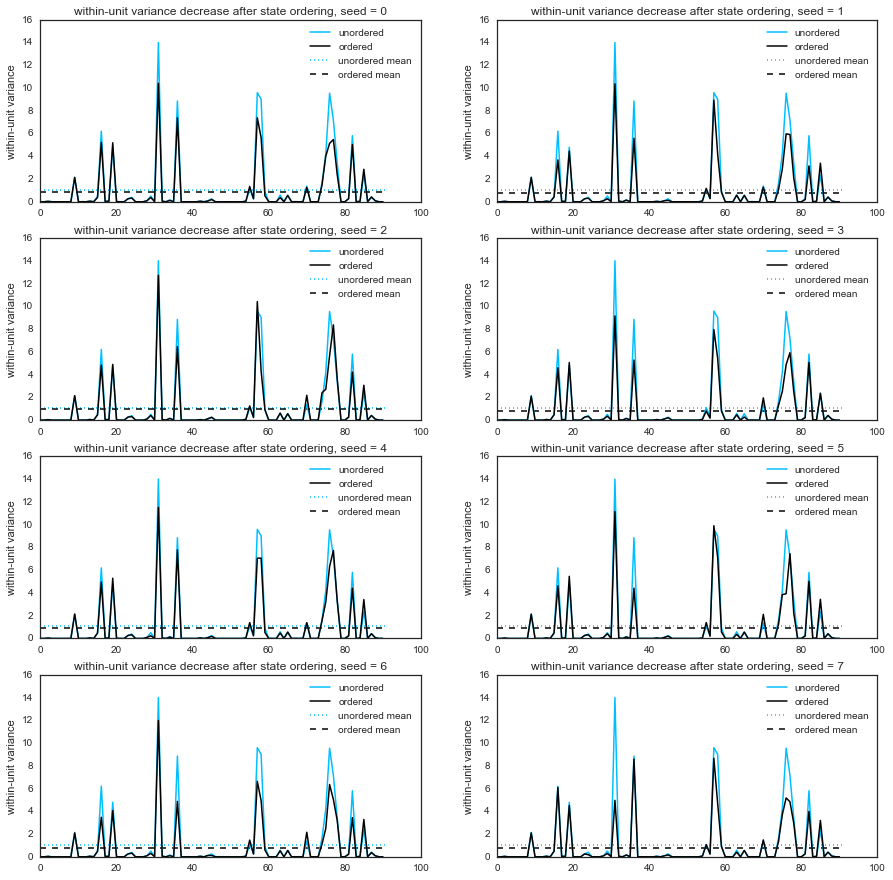

In [253]:
A = myhmm.means_.copy()
f1 = np.diff(A, axis=0)
v1 = np.var(f1,axis=0);

fig, axes = plt.subplots(4, 2, figsize=(15, 15))
axes = [item for sublist in axes for item in sublist]

for seed, ax in enumerate(axes):
    
    mds = manifold.MDS(n_components=1, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)

    pos = mds.fit(similarities).embedding_

    vals = np.array([x[0] for x in pos])
    sort_index = np.argsort(vals)

    f2 = np.diff(A[sort_index,:], axis=0)
    v2 = np.var(f2,axis=0)

    ax.plot(v1, label='unordered', color='deepskyblue')
    ax.plot(v2, label='ordered', color='k')
    ax.hlines(v1.mean(), xmin=0, xmax=len(v1), colors='deepskyblue', linestyles='dotted', label='unordered mean')
    ax.hlines(v2.mean(), xmin=0, xmax=len(v2), colors='k', linestyles='dashed', label='ordered mean')
    ax.legend()
    #ax.set_xlabel('unit')
    ax.set_ylabel('within-unit variance')
    ax.set_title('within-unit variance decrease after state ordering, seed = ' + str(seed))

We can see from the above results that for many random seeds, our MDS-based (Euclidean) linear ordering does indeed improve our within-unit variability, but not by as much as the greedy re-ordering based simply on the state transition probability matrix.

However, another way of finding an ordering would be to greedily sort the distance matrix directly. That is, we choose a start state, and we find the next state as the state with the smallest distance (in this case Eucdlidean distance) to the first state, out of the remaining state set, and so on.

Will such an approach do better or worse than MDS projected onto a linear subspace?

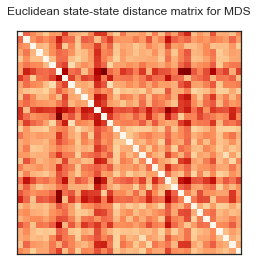

In [407]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.matshow(similarities, cmap='OrRd')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Euclidean state-state distance matrix for MDS')

0.45995347992338176

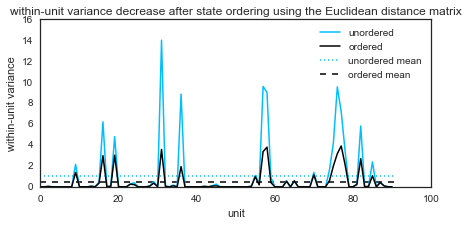

In [332]:
start_state = 18
new_order, Anew = get_sorted_order_from_transmat(1-similarities, start_state=start_state)

A = myhmm.means_.copy()
f1 = np.diff(A, axis=0)
f2 = np.diff(A[new_order,:], axis=0)
v1 = np.var(f1,axis=0); v2 = np.var(f2,axis=0)

fig, ax1 = plt.subplots(1, 1, figsize=(7, 3))
ax1.plot(v1, label='unordered', color='deepskyblue')
ax1.plot(v2, label='ordered', color='k')
ax1.hlines(v1.mean(), xmin=0, xmax=len(v1), colors='deepskyblue', linestyles='dotted', label='unordered mean')
ax1.hlines(v2.mean(), xmin=0, xmax=len(v2), colors='k', linestyles='dashed', label='ordered mean')
ax1.legend()
ax1.set_xlabel('unit')
ax1.set_ylabel('within-unit variance')
ax1.set_title('within-unit variance decrease after state ordering using the Euclidean distance matrix')
v2.mean()

**Fascinating!** The above approach (ordering based on a greedy sort of the Euclidean distance matrix) worked better than expected to resuce the within-unit variance! It is difficult to tell, qualitatively from the figures, which approach worked better: the sorting based on the state transition probability matrix, or the sorting based on the Euclidean distance. However, for this particular data set, the mean within-unit variability for the Euclidean distance matrix approach is 0.506, whereas for the state transition probability matrix, it is 0.567, so **the Euclidean distance based approach wins!**

**Note:** The above numbers (0.506 vs 0.567) were for the same starting state of 17. For other starting states, the improvements are similar, and in fact, for state 18, the Euclidean distance based approach leads to a within-unit variance of only **0.46**.

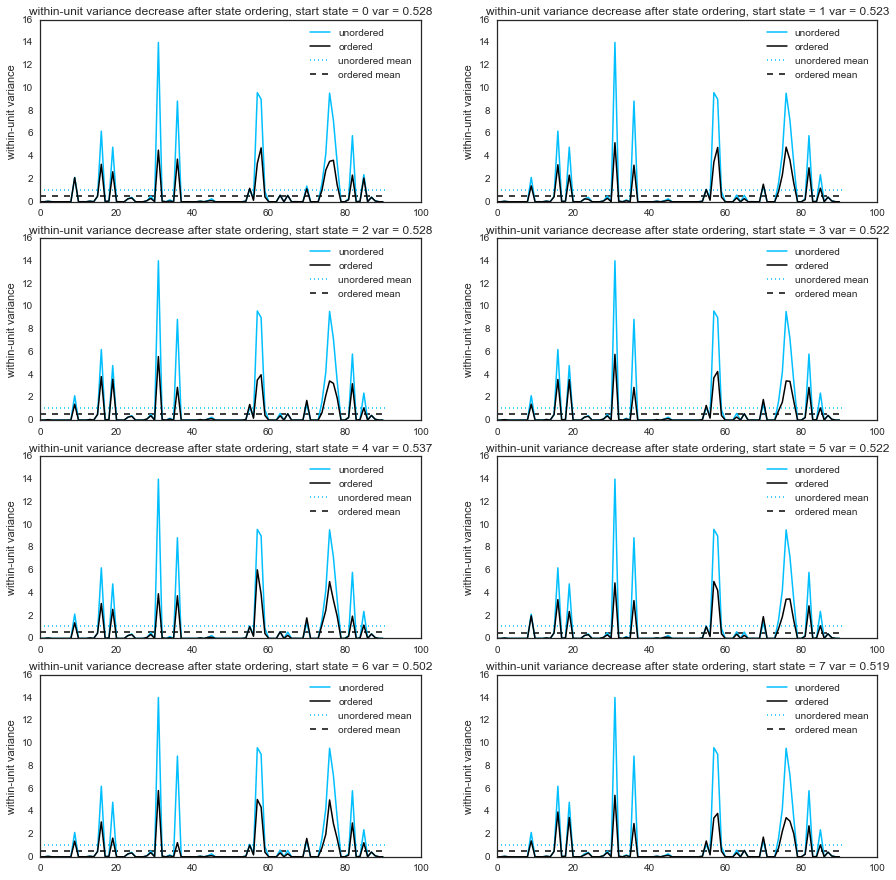

In [369]:
A = myhmm.means_.copy()
f1 = np.diff(A, axis=0)
v1 = np.var(f1,axis=0);

fig, axes = plt.subplots(4, 2, figsize=(15, 15))
axes = [item for sublist in axes for item in sublist]

for start_state, ax in enumerate(axes):
    
    new_order, Anew = get_sorted_order_from_transmat(1-similarities, start_state=start_state)

    f2 = np.diff(A[new_order,:], axis=0)
    v2 = np.var(f2,axis=0)

    ax.plot(v1, label='unordered', color='deepskyblue')
    ax.plot(v2, label='ordered', color='k')
    ax.hlines(v1.mean(), xmin=0, xmax=len(v1), colors='deepskyblue', linestyles='dotted', label='unordered mean')
    ax.hlines(v2.mean(), xmin=0, xmax=len(v2), colors='k', linestyles='dashed', label='ordered mean')
    ax.legend()
    #ax.set_xlabel('unit')
    ax.set_ylabel('within-unit variance')
    ax.set_title('within-unit variance decrease after state ordering, start state = ' + str(start_state) + ' var = ' + str(np.round(v2.mean()*1000)/1000))

Indeed, we see a robust decrease in within-unit variance across the different starting states, and all of the ones shown above are in fact better than what was obtained with the state transition probability matrix approach.

### Does a lower within-unit variance lead to more continuous trajectories?
This seems likely. A lower within-unit variance suggests smooth virtual place fields, which should lead to smoother or more continuous trajectories.

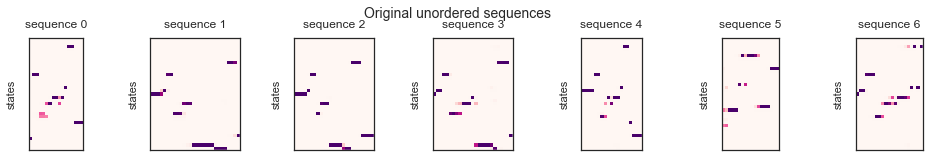

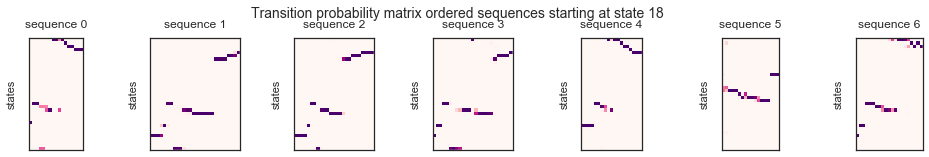

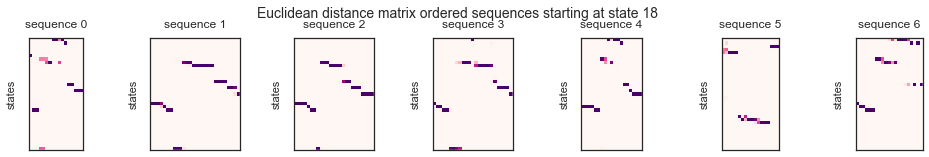

In [360]:
num_states = myhmm.n_components
similarities = euclidean_distances(myhmm.means_)

start_state = 18
A_order, Anew = get_sorted_order_from_transmat(myhmm.transmat_, start_state=start_state)
E_order, Anew = get_sorted_order_from_transmat(1-similarities, start_state=start_state)

tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(ts_b.sequence_lengths).tolist());

fig, axes = plt.subplots(1, 7, figsize=(17, 2))
#axes = [item for sublist in axes for item in sublist]

for ii, ax in enumerate(axes):
    obs = ts_b.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm.score_samples(obs)
    ax.matshow(np.transpose(pp), interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')
fig.suptitle('Original unordered sequences', fontsize=14, y=1.12)

fig2, axes2 = plt.subplots(1, 7, figsize=(17, 2))
#axes2 = [item for sublist in axes2 for item in sublist]

for ii, ax in enumerate(axes2):
    obs = ts_b.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm.score_samples(obs)
    ax.matshow(np.transpose(pp)[A_order,:], interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')
fig2.suptitle('Transition probability matrix ordered sequences starting at state ' + str(start_state), fontsize=14, y=1.12)

fig3, axes3 = plt.subplots(1, 7, figsize=(17, 2))
#axes2 = [item for sublist in axes2 for item in sublist]

for ii, ax in enumerate(axes3):
    obs = ts_b.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm.score_samples(obs)
    ax.matshow(np.transpose(pp)[E_order,:], interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')
fig3.suptitle('Euclidean distance matrix ordered sequences starting at state ' + str(start_state), fontsize=14, y=1.12)

We can see that both approaches improved the continuity of sequences. However, it should be mentioned that by cycling through all the starting states and using visual inspection, we can get examples which _look better_ for the probability matrix based approach than for the Euclidean distance based approach, even though the within-unit variance is lower for the Euclidean distance based approach. One such example is starting state 17, whose results are shown below.

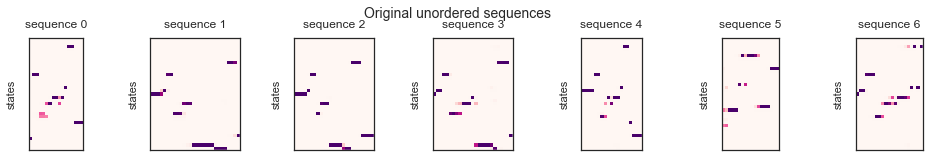

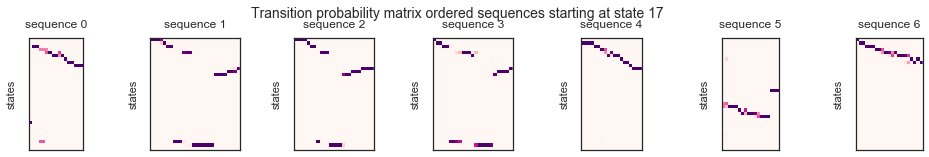

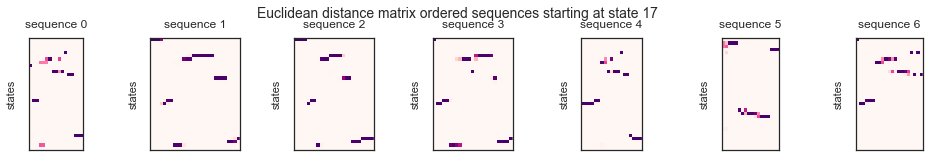

In [361]:
num_states = myhmm.n_components
similarities = euclidean_distances(myhmm.means_)

start_state = 17
A_order, Anew = get_sorted_order_from_transmat(myhmm.transmat_, start_state=start_state)
E_order, Anew = get_sorted_order_from_transmat(1-similarities, start_state=start_state)

tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(ts_b.sequence_lengths).tolist());

fig, axes = plt.subplots(1, 7, figsize=(17, 2))
#axes = [item for sublist in axes for item in sublist]

for ii, ax in enumerate(axes):
    obs = ts_b.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm.score_samples(obs)
    ax.matshow(np.transpose(pp), interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')
fig.suptitle('Original unordered sequences', fontsize=14, y=1.12)

fig2, axes2 = plt.subplots(1, 7, figsize=(17, 2))
#axes2 = [item for sublist in axes2 for item in sublist]

for ii, ax in enumerate(axes2):
    obs = ts_b.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm.score_samples(obs)
    ax.matshow(np.transpose(pp)[A_order,:], interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')
fig2.suptitle('Transition probability matrix ordered sequences starting at state ' + str(start_state), fontsize=14, y=1.12)

fig3, axes3 = plt.subplots(1, 7, figsize=(17, 2))
#axes2 = [item for sublist in axes2 for item in sublist]

for ii, ax in enumerate(axes3):
    obs = ts_b.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm.score_samples(obs)
    ax.matshow(np.transpose(pp)[E_order,:], interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')
fig3.suptitle('Euclidean distance matrix ordered sequences starting at state ' + str(start_state), fontsize=14, y=1.12)

**Conclusion:** MDS with a Euclidean distance didn't actually reduce the within-unit variance much when we used MDS to get a linear ordering. However, it was useful in discovering higher dimensional state associations (in 2D, or even 3D). However, a simple greedy approach to re-order based on the Euclidean distance matrix proved to be remarkably effective at reducing the within-unit variance, although it is unclear whether such a design criterion will necessarily always lead to the best visualization of sequences in the data.

### Hellinger distance with Poisson firing rates
The Euclidean distance is simple to compute and quick to try out, so it was a natural first choice. However, thinking about how "close" one state is to another is not necessarily captured best by a Euclidean distance between their $C$-dimensional firing rates. 

Since the firing rates are Poisson, I wanted to use the Hellinger distance (which is commonly used as a distance between probability distributions), and for Poisson distributions, we have a nice closed form for its computation.

In particular, I use the Hellinger distance to compute point-wise distances between different state-unit pairs. For example, for any pair of states $S_A$ and $S_B$ and an associated unit $u$, we have Poisson firing rates $u_A$ and $u_B$, so that we compute the squared Hellinger distance between these Poisson distributions as
$$
H^2\bigl(S_A(u),S_B(u)\bigr) = 1-\exp\biggl(-\frac{1}{2}\bigl(\sqrt{u_A} - \sqrt{u_B}\bigr)^2\biggr).
$$
Then we simply consider the pairwise distance between the two states as the average Hellinger distance over all the units:
$$
D(S_A,S_B) = \dfrac{1}{|U|}\sum_{u \in U} H\bigl(S_A(u), S_B(u) \bigr).
$$
Such a definition for a distance is intuitively appealing to me, but since we are averaging, it is also bounded.

First, let us look at the distance matrices that we obtain:

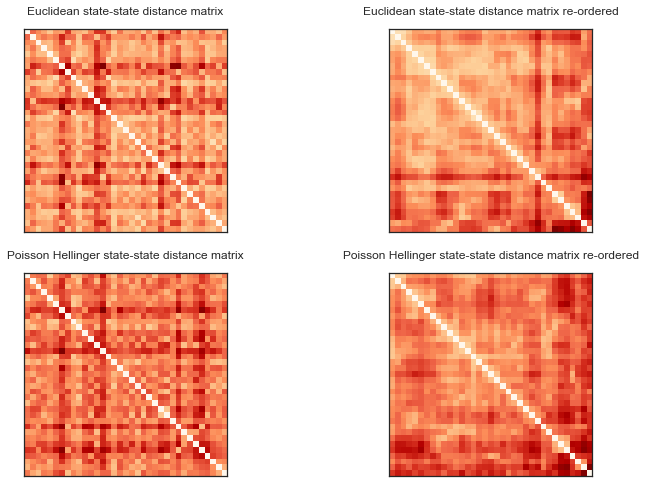

In [392]:
similaritiesPH = poisson_hellinger_distances(myhmm.means_)
similaritiesED = euclidean_distances(myhmm.means_)

similaritiesPH = similaritiesPH/similaritiesPH.max()
similaritiesED = similaritiesED/similaritiesED.max()

new_orderPH, matPH = get_sorted_order_from_transmat(1-similaritiesPH, start_state=start_state)
new_orderED, matED = get_sorted_order_from_transmat(1-similaritiesED, start_state=start_state)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
ax1.matshow(similaritiesED, cmap='OrRd')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_title('Euclidean state-state distance matrix')
ax2.matshow(matED, cmap='OrRd_r')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_title('Euclidean state-state distance matrix re-ordered')
ax3.matshow(similaritiesPH, cmap='OrRd')
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.set_title('Poisson Hellinger state-state distance matrix')
ax4.matshow(matPH, cmap='OrRd_r')
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.set_title('Poisson Hellinger state-state distance matrix re-ordered')

I don't really know how much we learn from looking at these distance matrices, but what we might hope for in an ideal distance function is that states that as a state gets further away in its ordering, the distance grows larger. That is, we would ideally like to see a monotone and gradual increase in distance spreading from the diagonal. We don't really see that very strongly in either of the above two approaches, although the (0,0) and (1,1) corners of the Hellinger based distance are noticeably darker (further away) and we have a reasonable amount of states for which the lighter zones (closer together) are those around the diagonal. So from this very crude and subjective analysis, we might expect the Hellinger based distance to be a nicer distance function than the Euclidean distance.

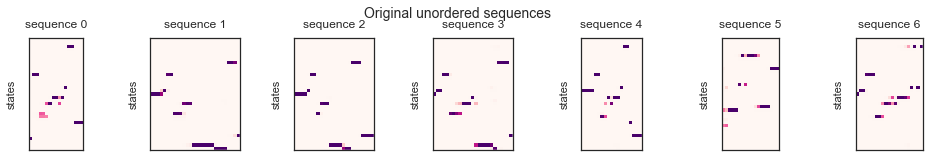

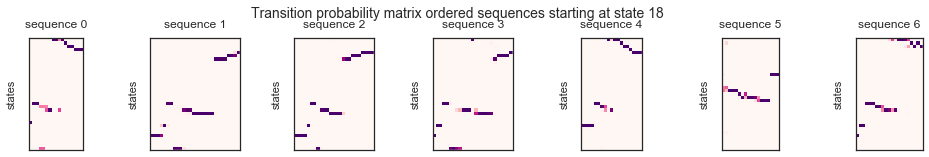

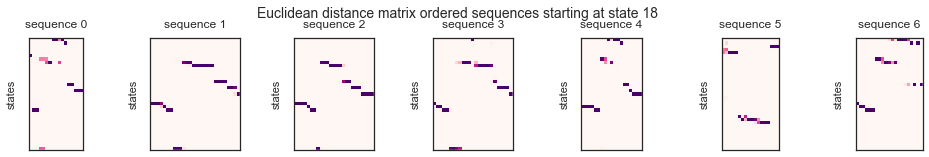

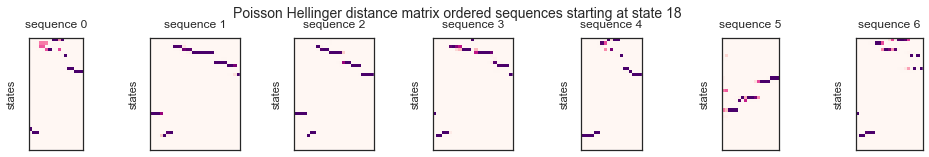

In [397]:
num_states = myhmm.n_components
similarities = euclidean_distances(myhmm.means_)

start_state = 18
A_order, Anew = get_sorted_order_from_transmat(myhmm.transmat_, start_state=start_state)
E_order, Anew = get_sorted_order_from_transmat(1-similarities, start_state=start_state)
P_order, Anew = get_sorted_order_from_transmat(1-similaritiesHP, start_state=start_state)

tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(ts_b.sequence_lengths).tolist());

fig, axes = plt.subplots(1, 7, figsize=(17, 2))
#axes = [item for sublist in axes for item in sublist]

for ii, ax in enumerate(axes):
    obs = ts_b.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm.score_samples(obs)
    ax.matshow(np.transpose(pp), interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')
fig.suptitle('Original unordered sequences', fontsize=14, y=1.12)

fig2, axes2 = plt.subplots(1, 7, figsize=(17, 2))
#axes2 = [item for sublist in axes2 for item in sublist]

for ii, ax in enumerate(axes2):
    obs = ts_b.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm.score_samples(obs)
    ax.matshow(np.transpose(pp)[A_order,:], interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')
fig2.suptitle('Transition probability matrix ordered sequences starting at state ' + str(start_state), fontsize=14, y=1.12)

fig3, axes3 = plt.subplots(1, 7, figsize=(17, 2))
#axes2 = [item for sublist in axes2 for item in sublist]

for ii, ax in enumerate(axes3):
    obs = ts_b.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm.score_samples(obs)
    ax.matshow(np.transpose(pp)[E_order,:], interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')
fig3.suptitle('Euclidean distance matrix ordered sequences starting at state ' + str(start_state), fontsize=14, y=1.12)

fig4, axes4 = plt.subplots(1, 7, figsize=(17, 2))
#axes2 = [item for sublist in axes2 for item in sublist]

for ii, ax in enumerate(axes4):
    obs = ts_b.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm.score_samples(obs)
    ax.matshow(np.transpose(pp)[P_order,:], interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')
fig4.suptitle('Poisson Hellinger distance matrix ordered sequences starting at state ' + str(start_state), fontsize=14, y=1.12)

The above results actually suggest that the Hellinger based distance might indeed be nice, since the sequences to look more continuous than with some of the other orderings. However, it still depends on the initial state, and even though the results are not shown here, the within-unit variance is quantitatively larger than for the Euclidean distance.

### TL;DR
Ordering states can be very hard, especially if no linear state ordering is even expected to exist. Here I've considered the case of a linear track where we do expect a linear state ordering, but even then, it is far from trivial to recover such an ordering.

The Euclidean distance based approach led to by far the lowest within-unit variance, but we can sometimes get better qualitative sequence representations by using either the state transition probability matrix approach (with a suitably chosen starting state!) or with the more appealing Hellinger distance based approach.

Multidimensional scaling by itself did not prove very effective in uncovering a linear state ordering, but it is nonetheless a poweferful tool to discover higher dimensional state associations.